<a href="https://colab.research.google.com/github/pr-nit/DecitionTree-SVM-Lesson/blob/main/Decision_Tree_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 決定木の構築/SVMの構築
1. 木を深くするにつれて識別境界がどのように変化するかを観察します。不純度を求める基準を変化させると、意外と識別境界が変わることのあることを体験します。
2. SVMでkernelを用いると境界が非線形になることを体験します。カーネル関数や正則化係数$C$を変更することで境界線の様相が変わることも観察します。

まず非線形な境界を持つデータを読み込みます。

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# style
colors = ['#e74c3c', '#3498db', '#1abc9c', '#9b59b6', '#f1c40f'] # red, blue, green, purple, yellow
cmap = ListedColormap(colors)
plt.style.use('seaborn')

# 三日月状に分布するデータの読み込み。Xがデータでyがクラスラベルラベル
X, y = make_moons(n_samples=100, noise=0.25, random_state=0)


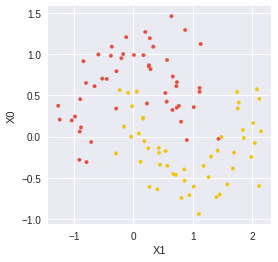

In [ ]:
# 図示します。
plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='.')
plt.ylabel('X0')
plt.xlabel('X1')

plt.show()

決定木を作ります。最大の深さを指定して剪定する方法を採用します。深さを変えたときに境界がどのように変化するか確認しましょう。

まず描画の準備をして、その次に木を作ります。

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
import matplotlib.image as mpimg # Added
import numpy as np

# style
colors = ['#e74c3c', '#3498db', '#1abc9c', '#9b59b6', '#f1c40f'] # red, blue, green, purple, yellow
cmap = ListedColormap(colors)
plt.style.use('seaborn')

def paint_classified_area(ax, clf, X, t, nx=100, ny=100, margin=0.1):
    x_min, x_max = (1 + margin) * X[:,0].min() - margin * X[:,0].max(), (1 + margin) * X[:,0].max() - margin * X[:,0].min()
    y_min, y_max = (1 + margin) * X[:,1].min() - margin * X[:,1].max(), (1 + margin) * X[:,1].max() - margin * X[:,1].min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = (clf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.1, colors=colors)

def export_tree_graph(graph_name, features, classes):
    dot_name="./dtc.dot"
    export_graphviz(dtc, 
                    out_file=dot_name, 
                    impurity = False, 
                    filled = False,
                    class_names=classes,
                    feature_names=features)
    graph = pydotplus.graph_from_dot_file(dot_name)
    graph.write_png(graph_name)
    img = mpimg.imread(graph_name)
    print(graph_name)
    imgplot = plt.imshow(img)

決定木を作ります。

1.   max_depthを１から次第に大きくして（9くらいまででOK)変化を観察しましょう
2.   不純度の算出法ををentropyからGiniに変更して木が変わるかどうか観察しましょう



accuracy:1.000
dtc9.pdf


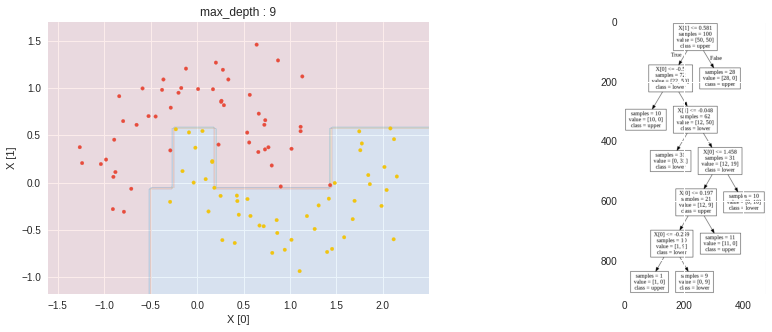

In [ ]:
# Prepare for the display of graphs
fig, ax = plt.subplots(1,2, figsize = (15, 5))

# Fit a Tree Model
max_depth = 2 # Input HERE
# Criterion can be entropy or gini
dtc = DecisionTreeClassifier(criterion="entropy",max_depth=max_depth, random_state=0)
dtc.fit(X, y)
print("accuracy:{:.3f}".format(dtc.score(X, y)))

# 結果の描画
paint_classified_area(ax[0], dtc, X, y)
    
ax[0].scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='.')
ax[0].set_title('max_depth : {}'.format(max_depth))
ax[0].set_xlabel("X [0]")
ax[0].set_ylabel("X [1]")
    
export_tree_graph(graph_name = "dtc{}.pdf".format(max_depth),features = ["X[0]","X[1]"], classes = ["upper","lower"])

# SVMの構築
同じデータに対してSVMを適用します。
SVMは二種類作ります。
一方は素のSVMで線形識別器です。「マージン」を最大にする線形な境界を求めます。もう一方ははkernel SVMです。カーネル関数には Radial Basis Function（俗称・ガウスカーネル）を使います。このカーネル関数は次式で与えられます。

$k(x,y) = \exp(-\gamma \| x - y\|^2)$

$\gamma$の値を変えると、境界線の「柔らかさ」が変わります。どのように変わるか見てみましょう。($\gamma$を小さくすると境界線は滑らかになると思います）

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


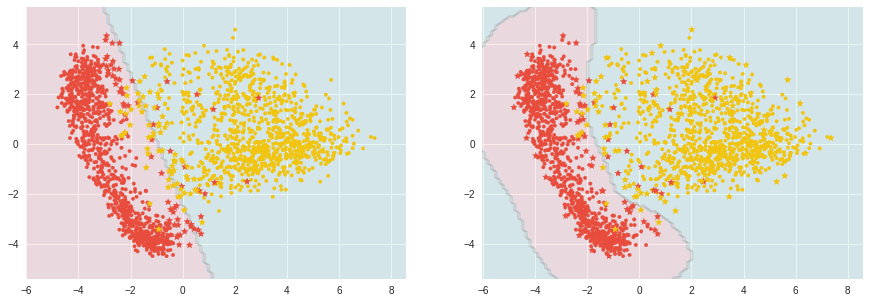

In [ ]:
from sklearn import svm

# Prepare for the display of graphs
fig, ax = plt.subplots(1,2, figsize = (15, 5))

# まず線形なSVMを適用します。kernel='linear'と指定することで線形になります。
svmc =svm.SVC(kernel = 'linear', C=1.0,class_weight='balanced', random_state=0) #loss='squared_hinge' #loss="hinge", loss="log"
svmc.fit(X, y)
# 線形SVMの結果を表示します。
paint_classified_area(ax[0], svmc, X, y )
ax[0].scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='.')
ax[0].scatter(X[svmc.support_, 0], X[svmc.support_, 1], c=y[svmc.support_], cmap=cmap, marker='*')

# 次にkernel SVMを適用します。kernel = 'rbf'と指定することでRBFをカーネルと出来ます。gammaの値を変えると境界線が変わります。
svmc =svm.SVC(kernel='rbf', gamma=1/2 , C=1.0,class_weight='balanced', random_state=0) #loss='squared_hinge' #loss="hinge", loss="log"
svmc.fit(X, y)
# kernel SVMの結果を表示します。
paint_classified_area(ax[1], svmc, X, y )
ax[1].scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='.')
ax[1].scatter(X[svmc.support_, 0], X[svmc.support_, 1], c=y[svmc.support_], cmap=cmap, marker='*')

PCAのときに観察した文字画像で同じ実験をしましょう。木構造については、784次元空間で木構造を作るのは現実的ではありません（ピクセル値ごとに分類する作戦が妥当とは思えません）。そこで、PCAで2次元に射影したあと決定木を適用します。SVMは784次元のデータを直接処理する能力がありますが、境界線を観察するために、木構造と同じようにPCAを適用したあとに適用します。

まずMNISTデータを読み込んでPCAします。対象とする文字をいろいろと変えるのも良いでしょう。

In [ ]:
import tensorflow as tf
from sklearn.decomposition import PCA

DNUM = 1024

# Load MNIST
mnist = tf.keras.datasets.mnist.load_data()
train, test = mnist
(x_train, y_train),(x_test, y_test) = mnist


#注目する数字 2種類 (7と9が難しい)
TARGET_0 = 1 # Input HERE
TARGET_1 = 7 # Input HERE

# TARGET_0
X0_all = x_train[y_train == TARGET_0, :, :]
X0 = X0_all[0:DNUM,:,:].reshape(DNUM,28*28)
X0 = X0 /255.0

# TARGET_1
X1_all = x_train[y_train == TARGET_1, :, :]
X1 = X1_all[0:DNUM,:,:].reshape(DNUM,28*28)
X1 = X1 /255.0

# Concatenate TARGET_0 and TARGET_1
X = np.concatenate( (X0, X1 ), axis=0)

# Apply PCA to the concatenated data.
D = 2
pca = PCA(n_components=D)
pca.fit(X)
X = pca.transform(X)

# Concatenate the laberl data
label0 = np.array([[TARGET_0]]* DNUM)
label1 = np.array([[TARGET_1]]* DNUM)
y = np.concatenate((label0, label1), axis=0)
# Xd = np.concatenate((Xd, label), axis = 1 )

2次元空間での分布を描画します。

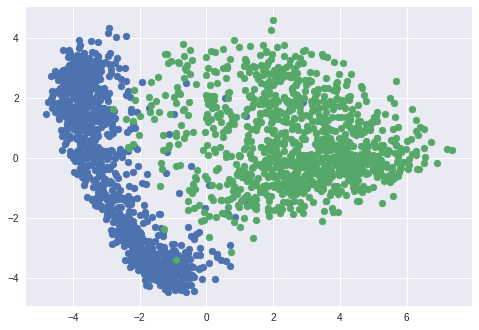

In [ ]:
plt.scatter( X[0:1024,0], X[0:1024,1] )
plt.scatter( X[1024:2048, 0], X[1024:2048,1] )

では木構造で文字認識をしましょう。深さを変えつつ実験します。挙動が分かったら文字種の組あわせを変えてみましょう。

accuracy:0.998
dtc10.pdf


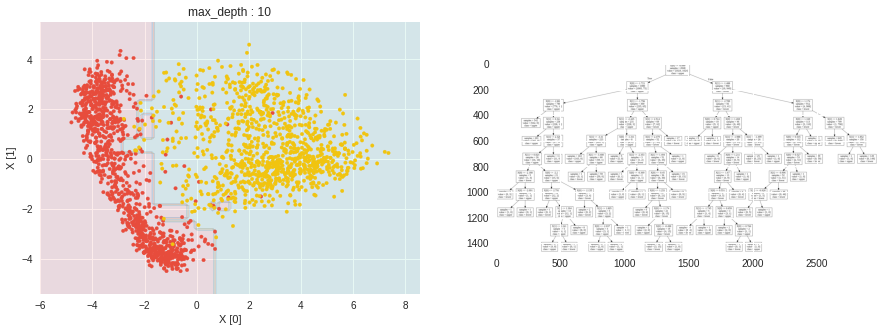

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))

# Fit a Tree Model
max_depth = 10 # Input HERE
# Criterion can be entropy or gini
dtc = DecisionTreeClassifier(criterion="entropy",max_depth=max_depth, random_state=0)
dtc.fit(X, y)
print("accuracy:{:.3f}".format(dtc.score(X, y)))

# 結果の描画
paint_classified_area(ax[0], dtc, X, y)
    
ax[0].scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='.')
ax[0].set_title('max_depth : {}'.format(max_depth))
ax[0].set_xlabel("X [0]")
ax[0].set_ylabel("X [1]")
    
export_tree_graph(graph_name = "dtc{}.pdf".format(max_depth),features = ["X[0]","X[1]"], classes = ["upper","lower"])

では、同じデータにSVMを適用してみましょう。斜めに境界線を引けるだけでも、随分と挙動が変わるものです。Cを大きくするほどデータの誤識別に不寛容になります。

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


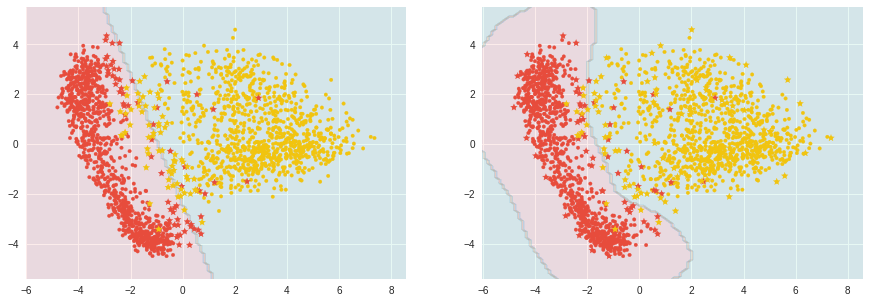

In [ ]:
from sklearn import svm

# Prepare for the display of graphs
fig, ax = plt.subplots(1,2, figsize = (15, 5))

# まず線形なSVMを適用します。kernel='linear'と指定することで線形になります。
svmc =svm.SVC(kernel = 'linear', C=1.0,class_weight='balanced', random_state=0) #loss='squared_hinge' #loss="hinge", loss="log"
svmc.fit(X, y)
# 線形SVMの結果を表示します。
paint_classified_area(ax[0], svmc, X, y )
ax[0].scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='.')
ax[0].scatter(X[svmc.support_, 0], X[svmc.support_, 1], c=y[svmc.support_], cmap=cmap, marker='*')

# 次にkernel SVMを適用します。kernel = 'rbf'と指定することでRBFをカーネルと出来ます。gammaの値を変えると境界線が変わります。
svmc =svm.SVC(kernel='rbf', gamma=1/2 , C=1.0,class_weight='balanced', random_state=0) #loss='squared_hinge' #loss="hinge", loss="log"
svmc.fit(X, y)
# kernel SVMの結果を表示します。
paint_classified_area(ax[1], svmc, X, y )
ax[1].scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='.')
ax[1].scatter(X[svmc.support_, 0], X[svmc.support_, 1], c=y[svmc.support_], cmap=cmap, marker='*')